# Image Classification using Satellite Images

# Importing the libraries

In [30]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 
import gc

from tensorflow import keras
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator


In [31]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

# defining the paths to our datasets

In [32]:
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

# Loading the train and test datasets

In [33]:
# loading the train dataset
train_df = pd.read_csv(train_path)
print(train_df.shape)
train_df.head(3)

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary


In [34]:
# loading the test dataset and printing first 3 rows
test_df = pd.read_csv(test_path)
print(test_df.shape)
test_df.head(3)

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water


# data preprocessing

In [35]:
# creating a copy of all our datasets and print our train dataset having two columns
train_df1 = train_df.copy()
train_df1

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [36]:
# Build list with unique labels
label_list = []
for tag_value in train_df1.tags.values:
    labels = tag_value.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
print(label_list)

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [37]:
# Add onehot features for every label in train dataset
for tag in label_list:
    train_df1[tag] = train_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# add .jpg as an extension to the column "image_name" to all the images e.g train_0.jpg 
train_df1['image_name'] = train_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))

In [38]:
# print the first 5 rows of the train dataset
train_df1.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [39]:
# Define the columns
columns = label_list
columns

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [40]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagenerator = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagenerator.flow_from_dataframe(dataframe=train_df1,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
valid_generator = train_datagenerator.flow_from_dataframe(dataframe=train_df1,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [41]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_valid_size = int(np.ceil(valid_generator.samples / valid_generator.batch_size))

#  Model Generation

In [66]:
# Defining the cnn model

def convolution_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    # Flatten layer - convert the multi-dimensional output of the last convolutional layer into a one-dimensional array, 
    # which will be fed into the fully connected layers.
    model.add(Flatten()) 

    # Fully connected layers
    model.add(Dense(512, activation='relu')) #hidden layer 1, 512neurons, ReLU activation
    model.add(Dense(512, activation='relu')) #hidden layer 2, 512neurons, ReLU activation
    model.add(Dense(512, activation='relu')) #hidden layer 3, 512neurons, ReLU activation
    model.add(Dropout(rate=0.5))
    model.add(Dense(17, activation='sigmoid')) # output layer, sigmoid activation
    
    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [67]:
#initializing the model & displaying the architecture of the model so far
model = convolution_model()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 128)      

In [68]:
# regularization using earlystopping (callbacks)
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [69]:
gc.collect()

11001

In [70]:
# the model training 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = valid_generator,
                    validation_steps = step_valid_size,
                    epochs = 10, 
                    callbacks = [earlystop])

Epoch 1/10
1012/1012 [==============================] - 961s 948ms/step - loss: 0.2093 - accuracy: 0.8468 - val_loss: 0.1631 - val_accuracy: 0.8310
Epoch 2/10
1012/1012 [==============================] - 958s 947ms/step - loss: 0.1577 - accuracy: 0.7970 - val_loss: 0.1472 - val_accuracy: 0.8489
Epoch 3/10
1012/1012 [==============================] - 954s 942ms/step - loss: 0.1451 - accuracy: 0.7622 - val_loss: 0.1387 - val_accuracy: 0.8526
Epoch 4/10
1012/1012 [==============================] - 954s 942ms/step - loss: 0.1358 - accuracy: 0.7333 - val_loss: 0.1482 - val_accuracy: 0.8456
Epoch 5/10
1012/1012 [==============================] - 934s 923ms/step - loss: 0.1291 - accuracy: 0.7687 - val_loss: 0.1312 - val_accuracy: 0.7990
Epoch 5: early stopping


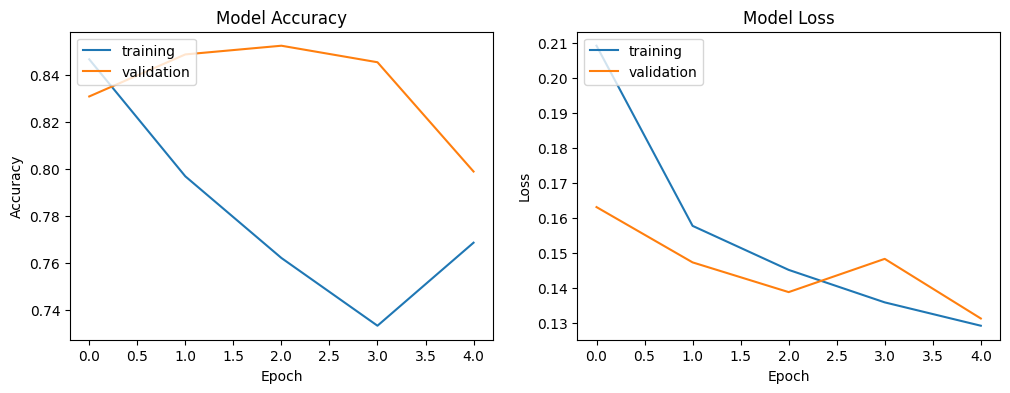

In [71]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [72]:
#initializing a second model to make predictions
model1 = convolution_model()

# loading & preprocessing of sample_submission file

In [73]:
# load the path to the sample_submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# copy the sample submisission file
sample_submission1 = sample_submission.copy()

#add .jpg extension to "image name" column in the sample submission file
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))


In [74]:
# display the first 5 rows in the dataset
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [75]:
len(sample_submission1)

61191

In [76]:
# split the sample submission dataset into 2
# working with the first half of the dataset
test_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [77]:
#initializing our Imagedatagenerator for the test images and also rescale
test_datagenerator = ImageDataGenerator(rescale = 1/255)

#creating our generator for the images found in the test image files
test_generator = test_datagenerator.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_generator.samples/test_generator.batch_size))

Found 40669 validated image filenames.


In [78]:
# resetting our test generator inorder to avoid index shuffling
test_generator.reset()
predict = model1.predict(test_generator, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 319s 251ms/step


In [79]:
len(predict)

40669

In [80]:
# using the attribute .filenames to Get the filenames in the generator 
file_names = test_generator.filenames

# Converts the predict values to a dataframe 
# if condition is met, merge two labels together 

predict_tags = pd.DataFrame(predict)
predict_tags = predict_tags.apply(lambda x: ' '.join(np.array(label_list)[x > 0.5]), axis = 1)

# prints result
result1 = pd.DataFrame({'image_name': file_names, 'tags': predict_tags})
result1.head()

,image_name,tags
0,test_0.jpg,haze primary habitation road cultivation slash...
1,test_1.jpg,haze primary habitation road cultivation slash...
2,test_2.jpg,haze primary habitation road cultivation slash...
3,test_3.jpg,haze primary habitation road cultivation slash...
4,test_4.jpg,haze primary road cultivation slash_burn conve...


In [81]:
# working with the second half of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [82]:
# create our generator for the second half of test image files
test_generator1 = test_datagenerator.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_generator1.samples/test_generator1.batch_size))

Found 20522 validated image filenames.


In [83]:
# resetting our test generator inorder to avoid index shuffling 
test_generator1.reset()

# making prediction on the generator
predict1 = model1.predict(test_generator1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 160s 249ms/step


In [84]:
# using the attribute .filenames to get the filenames in the generator 
file_names1 = test_generator1.filenames

# Converts the predict values to a dataframe 
# if condition is met, merge two labels together 

predict_tags1 = pd.DataFrame(predict1)
predict_tags1 = predict_tags1.apply(lambda x: ''.join(np.array(label_list)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': predict_tags1})
result2.head(3)

,image_name,tags
0,file_0.jpg,hazeprimaryhabitationroadcultivationslash_burn
1,file_1.jpg,hazeprimaryhabitationroadcultivationslash_burn...
2,file_10.jpg,hazeprimaryhabitationroadcultivationslash_burn...


In [85]:
# Final result = result1 + result2
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head(3)

(61191, 2)


,image_name,tags
0,test_0.jpg,haze primary habitation road cultivation slash...
1,test_1.jpg,haze primary habitation road cultivation slash...
2,test_2.jpg,haze primary habitation road cultivation slash...


In [86]:
# Removing the .jpg extension from the image_name of the final result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,haze primary habitation road cultivation slash...
1,test_1,haze primary habitation road cultivation slash...
2,test_2,haze primary habitation road cultivation slash...
3,test_3,haze primary habitation road cultivation slash...
4,test_4,haze primary road cultivation slash_burn conve...


In [87]:
# saving the result to a csv file using the .to_csv() & setting the index to false.
final_df.to_csv('submissionfinal.csv', index = False)

# Downloading our submission file

In [88]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submissionfinal.csv')